In [1]:
import sys

sys.path.append("./../../src")

from Dataset import SpeechCommandsDataset
from torch.utils.data import DataLoader
from Transformer import SpeechCommandTransformer, train_transformer, calculate_class_weights
import torch
import torch.nn as nn
from torch.optim import AdamW

In [2]:
torch.cuda.empty_cache()

In [ ]:
train_dataset = SpeechCommandsDataset("../../data/train", mode="modified")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6)

test_dataset = SpeechCommandsDataset("../../data/test", mode="modified")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpeechCommandTransformer(num_classes=len(train_dataset.class_to_idx), device=device, stride=2, embed_dim=64, pos_embedding=True).to(device)

class_weights = calculate_class_weights(train_dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=0.00005, weight_decay=0.001)

train_transformer(train_loader, test_loader, model=model, num_epochs=10, device=device, criterion=criterion, optimizer=optimizer)

Epoch 1/10:  21%|██        | 695/3292 [03:04<11:20,  3.82it/s, acc=16.2, loss=2.38]

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for waveforms, labels in train_loader:
        waveforms = waveforms.squeeze(1).to(device)
        labels = labels.to(device)
        outputs = model(waveforms)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

label_names = list(test_dataset.class_to_idx.keys())

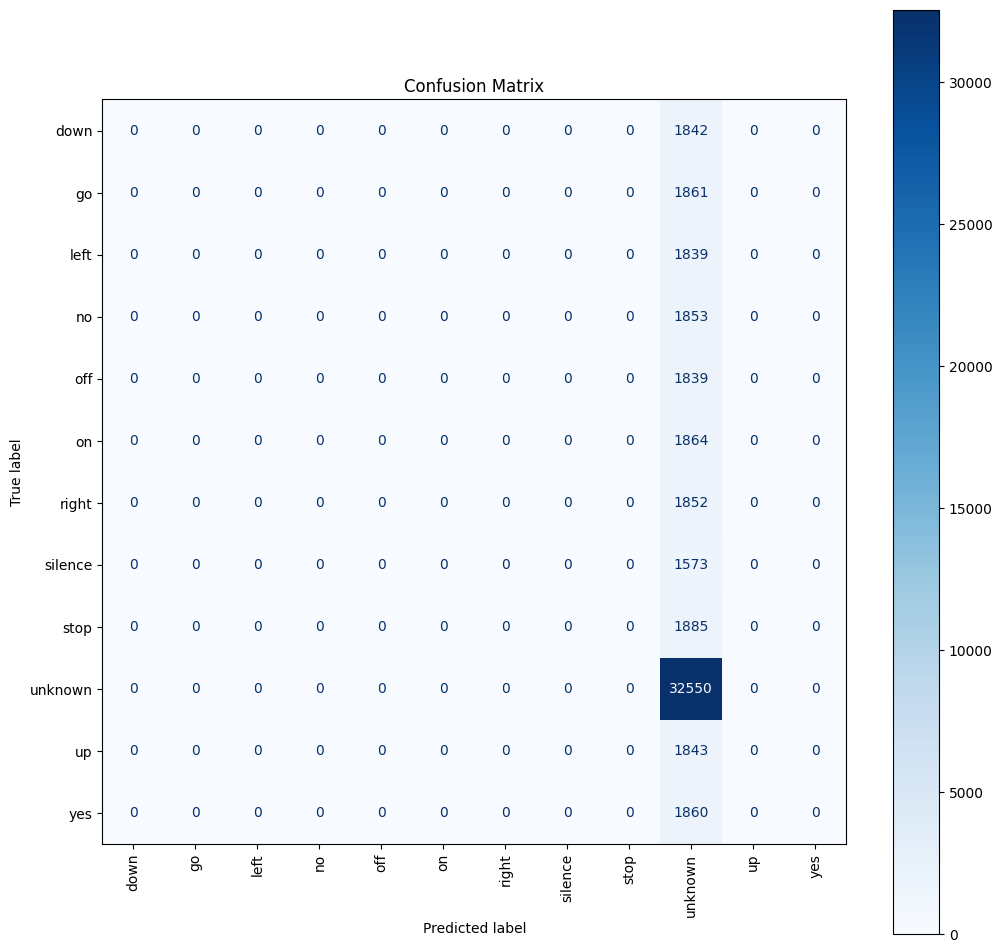

In [17]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation="vertical", ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()